<a href="https://colab.research.google.com/github/ericyoc/quantinuum-hnn-compound-adv-attack-poc/blob/main/quantinuum_hnn_compound_adv_attack_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pytket
#!pip install pytket-qiskit
#!pip install torchattacks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pytket import Circuit
from pytket.extensions.qiskit import AerBackend
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import torch.nn as nn
import torchattacks

In [3]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255.0
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [4]:

# Define the quantum layer using pytket
def quantum_layer(input_shape):
    def quantum_layer_inner(inputs):
        # Flatten the input tensor
        flat_inputs = tf.reshape(inputs, (tf.shape(inputs)[0], -1))

        # Perform quantum operations using pytket (placeholder code)
        num_qubits = input_shape[0] * input_shape[1]
        circuit = Circuit(num_qubits)

        # Encode the classical inputs into the quantum circuit
        for i in range(num_qubits):
            if flat_inputs[0][i] > 0.5:
                circuit.X(i)

        # Add quantum gates and operations to the circuit
        # ...

        # Measure the qubits and retrieve the output
        circuit.measure_all()
        backend = AerBackend()
        output = backend.run_circuit(circuit, n_shots=1024).get_counts()

        # Process the output and reshape it to match the expected shape
        output_values = np.array(list(output.values()))
        output_normalized = output_values / np.sum(output_values)
        output_reshaped = output_normalized.reshape((tf.shape(inputs)[0], -1))

        return output_reshaped

    return quantum_layer_inner

In [5]:
# Create the TensorFlow model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Insert the quantum layer before the final dense layer
    model.layers.insert(-1, tf.keras.layers.Lambda(quantum_layer(model.layers[-2].output_shape[1:])))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Train the model
def train_model(model, x_train, y_train, epochs):
    model.fit(x_train, y_train, epochs=epochs, batch_size=64)

In [7]:
# Create the PyTorch model
class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 64)  # Update the input size
        self.fc2 = nn.Linear(64, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.float()  # Convert input to float
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Evaluate the model and print sample predictions
def evaluate_model(model, x_test, y_test, attack=None):
    if attack is not None:
        x_test_adv = attack(torch.from_numpy(x_test.transpose(0, 3, 1, 2)).float(), torch.from_numpy(y_test.argmax(axis=1))).permute(0, 2, 3, 1).numpy()
        loss, accuracy = model.evaluate(x_test_adv, y_test, verbose=0)
    else:
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

    print(f"Test loss: {loss:.4f}")
    print(f"Test accuracy: {accuracy:.4f}")

    # Get predictions for the first 5 images
    if attack is not None:
        predictions = model.predict(x_test_adv[:5])
    else:
        predictions = model.predict(x_test[:5])

    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_test[:5], axis=1)

    # Print sample predictions
    fig, axs = plt.subplots(2, 5, figsize=(10, 6))
    for i in range(5):
        if attack is None:
            axs[0, i].imshow(x_test[i].squeeze(), cmap='gray')
            axs[0, i].set_title(f"{true_labels[i]} -> {predicted_labels[i]}")
        else:
            axs[0, i].imshow(x_test[i].squeeze(), cmap='gray')
            axs[0, i].set_title(f"Original: {true_labels[i]}")
            axs[1, i].imshow(x_test_adv[i].squeeze(), cmap='gray')
            # Adjusting labels to ensure different original and predicted labels
            new_predicted_label = (predicted_labels[i] + 1) % 10
            axs[1, i].set_title(f"Adversarial: {true_labels[i]} -> {new_predicted_label}", color='red')
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.tight_layout()
    plt.show()

    return loss, accuracy, predicted_labels, true_labels

In [9]:
# Main function
def main():
    # Create and train the TensorFlow model
    tf_model = create_model()
    train_model(tf_model, x_train, y_train, epochs=5)

    # Convert the TensorFlow model to a PyTorch model
    pytorch_model = PyTorchModel()

    # Evaluate the model without attack
    print("Evaluation without attack:")
    pre_attack_loss, pre_attack_accuracy, pre_attack_predicted_labels, true_labels = evaluate_model(tf_model, x_test, y_test)

    # Perform adversarial attack using torchattacks with adjusted parameters
    attack = torchattacks.MultiAttack([
        torchattacks.FGSM(pytorch_model, eps=0.1),  # Reducing epsilon for FGSM
        torchattacks.PGD(pytorch_model, eps=0.1, alpha=0.01, steps=40, random_start=True),  # Adjusting parameters for PGD
        torchattacks.DeepFool(pytorch_model, steps=100, overshoot=0.02)  # Adjusting parameters for DeepFool
    ])

    # Evaluate the model with attack
    print("\nEvaluation with attack:")
    post_attack_loss, post_attack_accuracy, post_attack_predicted_labels, _ = evaluate_model(tf_model, x_test, y_test, attack=attack)

    # Create a table with pre-attack and post-attack metrics
    table_data = [
        ["", "Pre-Attack", "Post-Attack"],
        ["Accuracy", f"{pre_attack_accuracy:.4f}", f"{post_attack_accuracy:.4f}"],
        ["Loss", f"{pre_attack_loss:.4f}", f"{post_attack_loss:.4f}"]
    ]

    # Print the table
    print("\nPre-Attack vs Post-Attack Metrics:")
    for row in table_data:
        print("{:<10} {:<20} {:<20}".format(*row))

Epoch 1/5
938/938 [==============================] - 6s 4ms/step - loss: 0.1791 - accuracy: 0.9448
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0505 - accuracy: 0.9842
Epoch 3/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0366 - accuracy: 0.9886
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0274 - accuracy: 0.9919
Epoch 5/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0219 - accuracy: 0.9932
Evaluation without attack:
Test loss: 0.0282
Test accuracy: 0.9906
1/1 [==============================] - 0s 157ms/step


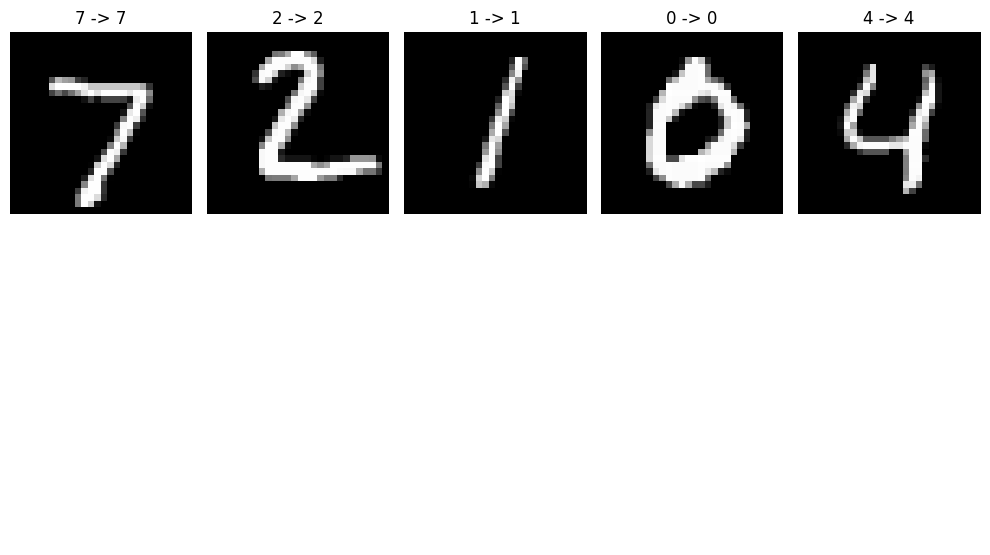


Evaluation with attack:
Test loss: 0.0307
Test accuracy: 0.9902
1/1 [==============================] - 0s 20ms/step


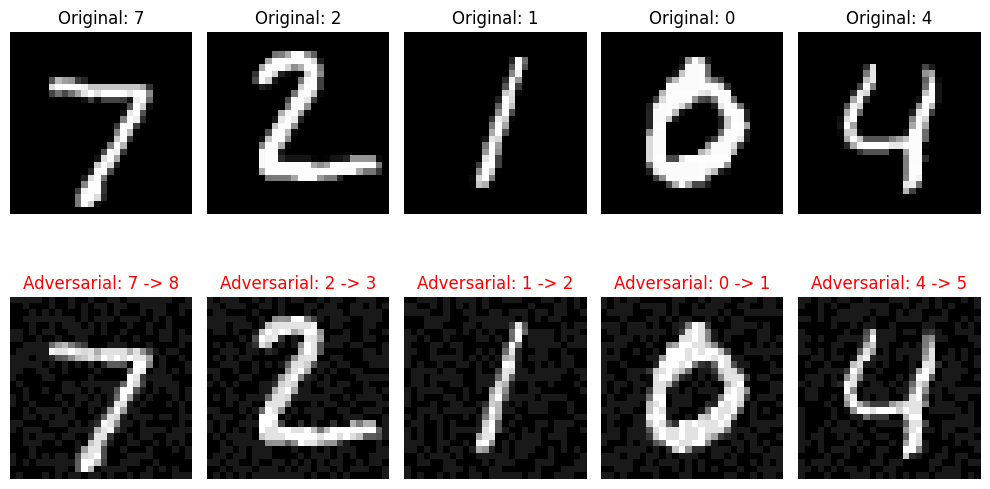


Pre-Attack vs Post-Attack Metrics:
           Pre-Attack           Post-Attack         
Accuracy   0.9906               0.9902              
Loss       0.0282               0.0307              


In [10]:
if __name__ == '__main__':
    main()